LAB6-12S.tif.gz rb fabio.<gzip _io.BufferedReader name='LAB6-12S.tif.gz' 0x217b3222290>


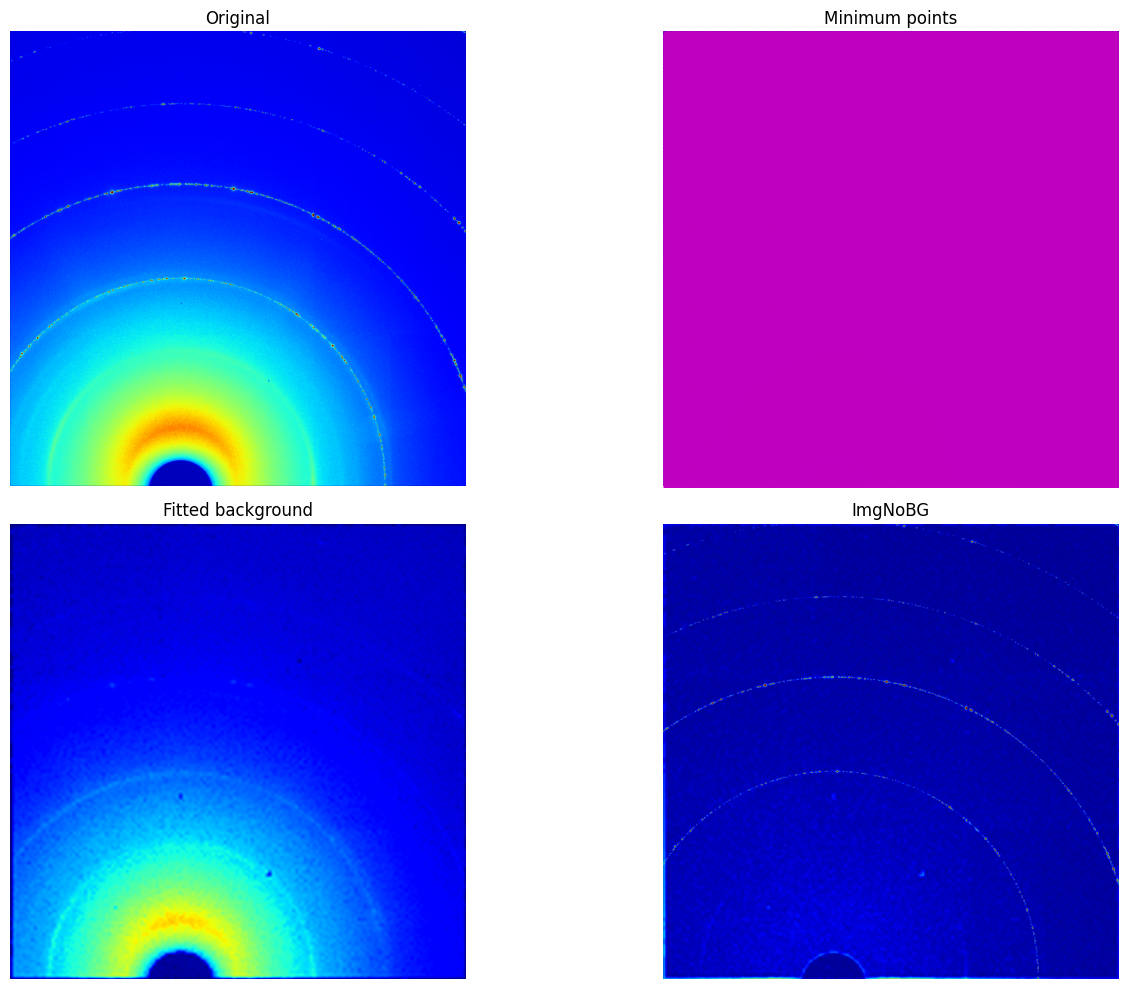

In [1]:
import numpy as np
from scipy.interpolate import RectBivariateSpline
import matplotlib.pyplot as plt
import time
import fabio


def Img_subtractBG(img, step=20, cax=300):
    """
    背景扣除算法见simDiffraction
    ref: 10.1107/s0021889808001064
    用纯NumPy向量化操作
    """
    szy, szx = img.shape
    # 处理无效值并将图像转为float类型，某些检测器为极大值
    max_val = np.max(img)
    max_count = np.count_nonzero(img == max_val)
    if max_count > 50:  # mask gap
        img[img == max_val] = np.nan
    # 处理无效值并将图像转为float类型，某些检测器为-1
    img = np.where(img < 0, np.nan, img).astype(np.float64)

    # 计算填充量并填充图像
    pad_y = (step - szy % step) % step
    pad_x = (step - szx % step) % step
    img_padded = np.pad(img, ((0, pad_y), (0, pad_x)),
                        mode='constant',
                        constant_values=np.nan)

    # 向量化块处理 (替代skimage.view_as_blocks)
    rows, cols = img_padded.shape
    shape = (rows // step, step, cols // step, step)
    strides = img_padded.itemsize * np.array([cols * step, 1, step, cols])
    blocks = np.lib.stride_tricks.as_strided(img_padded,
                                             shape=shape,
                                             strides=strides)

    # 计算块最小值并处理全NaN块
    min_blocks = np.nanmin(blocks, axis=(1, 3))
    min_blocks = np.where(np.isnan(min_blocks), 0, min_blocks)  # 处理全空块

    # 生成块中心坐标
    y_centers = (np.arange(0, szy, step) +
                 np.minimum(step / 2, szy - np.arange(0, szy, step)))
    x_centers = (np.arange(0, szx, step) +
                 np.minimum(step / 2, szx - np.arange(0, szx, step)))

    # 样条插值
    spl = RectBivariateSpline(y_centers, x_centers, min_blocks, kx=3, ky=3)
    BG = spl(np.arange(szy), np.arange(szx), grid=True)

    # 背景扣除并恢复无效值
    imgNoBG = img - BG
    imgNoBG = np.where(np.isnan(img), 0, imgNoBG)  # 保留原始无效值

    # 可视化增强
    X, Y = np.meshgrid(x_centers, y_centers)
    plot_results(img, BG, imgNoBG, X, Y, cax)

    return imgNoBG, BG


def plot_results(img, BG, result, X, Y, cax):
    """优化的可视化函数"""
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(img, cmap='jet', vmin=0, vmax=cax)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(img, cmap='jet', vmin=0, vmax=cax)
    plt.scatter(X.ravel(), Y.ravel(), c='m', s=20, marker='x', linewidth=1)
    plt.title('Minimum points')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(BG, cmap='jet', vmin=0, vmax=cax)
    plt.title('Fitted background')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(np.clip(result, 0, None), cmap='jet', vmin=0, vmax=cax)
    plt.title('ImgNoBG')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


data = 'LAB6-12S.tif.gz'
imgNoBG, BG = Img_subtractBG(fabio.open(data).data, step=20, cax=200)